In [1]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import getpass  # To get the password without showing the input
password = getpass.getpass()

········


In [3]:
#After trial and error, I decided to extract 2 files -1 with all movies and another with all rentals in May
#and will append a rental_flag that way.

In [2]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)
query = '''SELECT f.film_id, f.release_year, f.length, f.rental_rate, f.rating, fc.category_id
FROM sakila.film f
JOIN film_category fc
ON f.film_id = fc.film_id;'''


films = pd.read_sql_query(query, engine)
films.head()

,film_id,release_year,length,rental_rate,rating,category_id
0,19,2006,113,0.99,PG,1
1,21,2006,129,4.99,R,1
2,29,2006,168,2.99,NC-17,1
3,38,2006,68,0.99,NC-17,1
4,56,2006,129,2.99,G,1


In [4]:
films.shape

(1000, 6)

In [5]:
query = '''SELECT f.film_id, r.rental_date
FROM sakila.film f
JOIN sakila.inventory i
ON  f.film_id = i.film_id
JOIN sakila.rental r
ON i.inventory_id = r.inventory_id
WHERE r.rental_date BETWEEN '2005-05-01' AND '2005-05-31';'''


rented_may = pd.read_sql_query(query, engine)
rented_may.head()

,film_id,rental_date
0,80,2005-05-24 22:53:30
1,333,2005-05-24 22:54:33
2,373,2005-05-24 23:03:39
3,535,2005-05-24 23:04:41
4,450,2005-05-24 23:05:21


In [6]:
rented_may.shape

(993, 2)

In [58]:
#Now I have to merge my 2 files and makes sure I have a flag to know which movies has been rented or not. 

In [7]:
mov_flag = pd.merge(left = films,
                    right = rented_may,
                    how = 'left', 
                    left_on = "film_id", 
                    right_on= "film_id")
display(mov_flag.shape)
mov_flag.head()

(1366, 7)

,film_id,release_year,length,rental_rate,rating,category_id,rental_date
0,19,2006,113,0.99,PG,1,2005-05-28 12:08:37
1,21,2006,129,4.99,R,1,2005-05-25 21:58:58
2,21,2006,129,4.99,R,1,2005-05-26 08:04:38
3,29,2006,168,2.99,NC-17,1,NaT
4,38,2006,68,0.99,NC-17,1,NaT


In [8]:
#But now I have duplicates because some movies were rented multiple times in May
#Dropping duplicates based on film_id to get a clean list of movies. 

In [9]:
mov_drop = mov_flag.drop_duplicates(subset='film_id', keep="first")
mov_drop

,film_id,release_year,length,rental_rate,rating,category_id,rental_date
0,19,2006,113,0.99,PG,1,2005-05-28 12:08:37
1,21,2006,129,4.99,R,1,2005-05-25 21:58:58
3,29,2006,168,2.99,NC-17,1,NaT
4,38,2006,68,0.99,NC-17,1,NaT
5,56,2006,129,2.99,G,1,2005-05-26 20:57:00
...,...,...,...,...,...,...,...
1359,931,2006,48,0.99,PG-13,16,2005-05-25 19:30:46
1361,977,2006,85,2.99,R,16,NaT
1362,981,2006,55,0.99,NC-17,16,NaT
1363,988,2006,139,2.99,R,16,NaT


In [10]:
mov_clean = mov_drop.copy()

In [11]:
#creating a rental_flag. 

In [12]:
mov_clean[['rental_date']] = mov_clean[['rental_date']].fillna(value=0)
mov_clean.head()

,film_id,release_year,length,rental_rate,rating,category_id,rental_date
0,19,2006,113,0.99,PG,1,2005-05-28 12:08:37
1,21,2006,129,4.99,R,1,2005-05-25 21:58:58
3,29,2006,168,2.99,NC-17,1,0
4,38,2006,68,0.99,NC-17,1,0
5,56,2006,129,2.99,G,1,2005-05-26 20:57:00


In [13]:
def flagging(x):
    if x == 0:
        return 0
    else: 
        return 1
    
mov_clean['rental_flag'] = mov_clean['rental_date'].apply(flagging)
display(mov_clean.shape)
mov_clean.head()

(1000, 8)

,film_id,release_year,length,rental_rate,rating,category_id,rental_date,rental_flag
0,19,2006,113,0.99,PG,1,2005-05-28 12:08:37,1
1,21,2006,129,4.99,R,1,2005-05-25 21:58:58,1
3,29,2006,168,2.99,NC-17,1,0,0
4,38,2006,68,0.99,NC-17,1,0,0
5,56,2006,129,2.99,G,1,2005-05-26 20:57:00,1


In [14]:
mov_clean['rental_flag'].value_counts()

1    627
0    373
Name: rental_flag, dtype: int64

In [15]:
mov_clean = mov_clean.drop(['film_id', 'rental_date', 'release_year'],axis=1)
mov_clean
#the film_id is irrelevant for the model, rental_date would have perfect correlation to rental_flag and release year is 2006 for all movies so useless.

,length,rental_rate,rating,category_id,rental_flag
0,113,0.99,PG,1,1
1,129,4.99,R,1,1
3,168,2.99,NC-17,1,0
4,68,0.99,NC-17,1,0
5,129,2.99,G,1,1
...,...,...,...,...,...
1359,48,0.99,PG-13,16,1
1361,85,2.99,R,16,0
1362,55,0.99,NC-17,16,0
1363,139,2.99,R,16,0


In [16]:
mov_clean.dtypes

length           int64
rental_rate    float64
rating          object
category_id      int64
rental_flag      int64
dtype: object

In [17]:
data = mov_clean

In [18]:
data.shape

(1000, 5)

In [19]:
data.dtypes

length           int64
rental_rate    float64
rating          object
category_id      int64
rental_flag      int64
dtype: object

In [20]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
length,1000.0,115.272,40.426332,46.00,80.00,114.00,149.25,185.00
rental_rate,1000.0,2.980,1.646393,0.99,0.99,2.99,4.99,4.99
category_id,1000.0,8.478,4.610290,1.00,5.00,8.00,13.00,16.00
rental_flag,1000.0,0.627,0.483844,0.00,0.00,1.00,1.00,1.00


In [21]:
data.isna().sum()

length         0
rental_rate    0
rating         0
category_id    0
rental_flag    0
dtype: int64

In [22]:
#It seems all movies were released in 2006 so won't be useful
#Will explore values of rental rates as might be just a few values so categorical rather than numerical. 

In [23]:
data['rental_rate'].value_counts()

0.99    341
4.99    336
2.99    323
Name: rental_rate, dtype: int64

In [24]:
data['rental_rate'] = data['rental_rate'].astype('object')

In [25]:
#Category ID is a cateogrical, so changing type, as well as rental flag. 

In [26]:
data['category_id'] = data['category_id'].astype('object')

In [27]:
# data['rental_flag'] = data['rental_flag'].astype('object')

In [28]:
data.dtypes

length          int64
rental_rate    object
rating         object
category_id    object
rental_flag     int64
dtype: object

<AxesSubplot:xlabel='length', ylabel='count'>

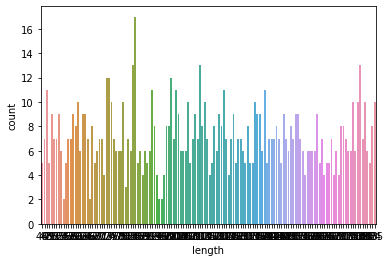

In [29]:
import seaborn as sns
%matplotlib inline
sns.countplot(x=data.length)

In [30]:
#Wanted to see if the length has some sort of a distribution, but seems fairly random

In [31]:
#Will create X/y train/test spliut then normalize the numerical data

In [32]:
y = data['rental_flag']
X = data.drop('rental_flag', axis=1)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1337)

In [33]:
X_train.shape

(800, 4)

In [34]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import StandardScaler

X_train_num = X_train.select_dtypes(include = np.number)

# Scaling data
transformer = MinMaxScaler().fit(X_train_num) # need to keep transformer
X_train_normalized = transformer.transform(X_train_num)
X_train_norm = pd.DataFrame(X_train_normalized)
X_train_norm.columns = X_train_num.columns
X_train_norm.head()

,length
0,0.366906
1,0.273381
2,0.366906
3,0.791367
4,0.741007


In [ ]:
#using onehot encoder for categoricals

In [35]:
X_train_categorical = X_train.select_dtypes(object)

In [36]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder().fit(X_train_categorical)
print(encoder.categories_)
encoded = encoder.transform(X_train_categorical).toarray()
print(encoded)
cols = [colname for row in encoder.categories_ for colname in row]
cols
onehot_encoded = pd.DataFrame(encoded, columns=cols)
cols_to_drop = [row[0] for row in encoder.categories_]
cols_to_drop
onehot_encoded = onehot_encoded.drop(cols_to_drop,axis=1)
onehot_encoded.head()

[array([0.99, 2.99, 4.99], dtype=object), array(['G', 'NC-17', 'PG', 'PG-13', 'R'], dtype=object), array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
      dtype=object)]
[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 1. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]


,2.99,4.99,NC-17,PG,PG-13,R,2,3,4,5,...,7,8,9,10,11,12,13,14,15,16
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
X_train_transformed = pd.concat([X_train_norm, onehot_encoded], axis=1)

In [38]:
X_train_transformed.dtypes#just checking

length    float64
2.99      float64
4.99      float64
NC-17     float64
PG        float64
PG-13     float64
R         float64
2         float64
3         float64
4         float64
5         float64
6         float64
7         float64
8         float64
9         float64
10        float64
11        float64
12        float64
13        float64
14        float64
15        float64
16        float64
dtype: object

In [ ]:
#using the existing transformer and encoder to create X_test_transformed

In [45]:
X_test_num = X_test.select_dtypes(include = np.number)

X_test_normalized = transformer.transform(X_test_num)
X_test_norm = pd.DataFrame(X_test_normalized)
X_test_norm.columns = X_test_num.columns
X_test_norm.head()

,length
0,1.000000
1,0.604317
2,0.007194
3,0.575540
4,0.525180


In [47]:
X_test_categorical = X_test.select_dtypes(object)

encoded_test = encoder.transform(X_test_categorical).toarray()
print(encoded_test)
cols = [colname for row in encoder.categories_ for colname in row]
cols
onehot_encoded_test = pd.DataFrame(encoded_test, columns=cols)
cols_to_drop = [row[0] for row in encoder.categories_]
cols_to_drop
onehot_encoded_test = onehot_encoded_test.drop(cols_to_drop,axis=1)
onehot_encoded_test.head()

[[0. 1. 0. ... 0. 0. 1.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]


,2.99,4.99,NC-17,PG,PG-13,R,2,3,4,5,...,7,8,9,10,11,12,13,14,15,16
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [48]:
X_test_transformed = pd.concat([X_test_norm, onehot_encoded_test], axis=1)

In [39]:
#doing the Logistic Regression and also testing KNN to see if it performs better

dtype('int64')

In [53]:
from sklearn.linear_model import LogisticRegression
classification_lbfgs = LogisticRegression(random_state=0, solver='lbfgs',
                  multi_class='multinomial').fit(X_train_transformed, y_train)

/Users/lex/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float', 'int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [56]:
predictions_lbfgs = classification_lbfgs.predict(X_test_transformed)
classification.score(X_test_transformed, y_test)

/Users/lex/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float', 'int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/lex/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float', 'int', 'str']. An error will be raised in 1.2.
  warnings.warn(


0.6

In [59]:
# For the cateogry_id columns I have left the column headers as inegers, which is creating this warning. 

In [ ]:
#Want to test a KNN option as well to see if the model score improves. 

In [50]:
from sklearn import neighbors
clf = neighbors.KNeighborsClassifier(n_neighbors=3, weights='uniform')
clf.fit(X_train_transformed, y_train)
predictions_clf = clf.predict(X_test_transformed)
clf.score(X_test_transformed, y_test)

/Users/lex/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float', 'int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/lex/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float', 'int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/lex/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float', 'int', 'str']. An error will be raised in 1.2.
  warnings.warn(


0.555